# 카카오 머신러닝 개발자 채용 과제

## 1. 주요 라이브러리 Import

In [1]:
import os
import ray
import psutil

# 분산처리를 위한 환경 Setting
ray.init(num_cpus=psutil.cpu_count())
os.environ["MODIN_ENGINE"] = "ray"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import csv

pd.set_option('display.max.colwidth', 10)

C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)


## 2. 데이터 통찰

### 2.1 데이터 Load

In [2]:
df_lst = glob('ctr_prediction_0704/*')

for e in df_lst:
    if 'train' in e:
        train_path = e
    elif 'test' in e:
        test_path = e

f1 = open(train_path, 'r')
rdr = csv.reader(f1)
train = pd.DataFrame(data=rdr, columns= ['index','userId','gender','age','slotid','device',
                                  'connection_type', 'activity1','activity2','activity3',
                                  'interest_list','interest_count','ad_feature1','ad_feature2',
                                  'ad_feature3', 'ad_feature4','timestamp','click'])
f1.close()
f2 = open(test_path, 'r')
rdr2 = csv.reader(f2)
test = pd.DataFrame(data=rdr2, columns=  ['index','userId','gender','age','slotid','device',
                                  'connection_type', 'activity1','activity2','activity3',
                                  'interest_list','interest_count','ad_feature1','ad_feature2',
                                  'ad_feature3', 'ad_feature4','timestamp'])

f2.close()

print('학습 데이터 총 row 수 :', len(train))
print('테스트 데이터 총 row 수 :', len(test))

학습 데이터 총 row 수 : 1527731
테스트 데이터 총 row 수 : 209106


,index,userId,gender,age,slotid,device,connection_type,activity1,activity2,activity3,interest_list,interest_count,ad_feature1,ad_feature2,ad_feature3,ad_feature4,timestamp,click
0,185346,US0000...,F,41,4b41ff...,Android,Wifi,15,16,b5531f...,SC0000...,3,cfc978...,53ab29...,433bb4...,edd35c...,155780...,0
1,129653,US0000...,M,41,8b20b6...,Android,Unknown,0,28,a3a666...,,0,c19a75...,8389a7...,3fb304...,26b211...,155780...,0
2,109040,US0000...,F,20,0e6da4...,Android,Cellular,371,13,b5531f...,SC0000...,3,73b196...,4b9a9a...,84121b...,6327ec...,155784...,0
3,23061,US0000...,M,31,8b20b6...,Android,Unknown,2,27,cfb81e...,,0,c19a75...,8389a7...,3fb304...,26b211...,155778...,0
4,20544,US0000...,M,26,0e6da4...,Android,Wifi,0,26,cfb81e...,,0,d2a53a...,fb2d2a...,07cc82...,3139e7...,155782...,0


### 2.2 Data 특성 파악

In [3]:
for e in train.columns:
    print('%s 컬럼의 데이터 종류의 수 :'%e, len(train[e].unique()))
    print()

index 컬럼의 데이터 종류의 수 : 258291

userId 컬럼의 데이터 종류의 수 : 463849

gender 컬럼의 데이터 종류의 수 : 2

age 컬럼의 데이터 종류의 수 : 6

slotid 컬럼의 데이터 종류의 수 : 6

device 컬럼의 데이터 종류의 수 : 2

connection_type 컬럼의 데이터 종류의 수 : 3

activity1 컬럼의 데이터 종류의 수 : 669

activity2 컬럼의 데이터 종류의 수 : 24

activity3 컬럼의 데이터 종류의 수 : 7

interest_list 컬럼의 데이터 종류의 수 : 348916

interest_count 컬럼의 데이터 종류의 수 : 883

ad_feature1 컬럼의 데이터 종류의 수 : 6364

ad_feature2 컬럼의 데이터 종류의 수 : 10557

ad_feature3 컬럼의 데이터 종류의 수 : 1384

ad_feature4 컬럼의 데이터 종류의 수 : 5330

timestamp 컬럼의 데이터 종류의 수 : 512388

click 컬럼의 데이터 종류의 수 : 2



1. index와 userId와 Timestamp 그리고 interest_list를 제외한 나머지는 모두 Categorical
    - 이유 : 전체 데이터 수(1527731개)에 대하여, 특성 수가 매우 적음
    
    
2. interest_list는 '|'로 구분된 문자열의 집합이므로 Categorical.
    - 데이터 전처리의 필요성 有


3. click이 0 또는 1 => binary


4. index가 row_id라고 명기되어있으나, index가 고유한 행을 나타내지 못함. => index Drop


5. userId로 Click을 예측하는 것은 특성 정보로서 Robust하지 못함. (Test Set에서 해당 User가 없을 수 있음 : Drop)


6. TimeStamp 데이터가 수치형이기 때문에 Categorical로 바꿔줘야함.

### 2.3 결측치 존재여부 점검

In [5]:
train.isna().sum()

index              0
userId             0
gender             0
age                0
slotid             0
device             0
connection_type    0
activity1          0
activity2          0
activity3          0
interest_list      0
interest_count     0
ad_feature1        0
ad_feature2        0
ad_feature3        0
ad_feature4        0
timestamp          0
click              0
dtype: int64

- 결측치가 존재하지 않으므로 Data가 무결하다고 판단하고 분석을 진행하겠다.

## 3. 데이터 전처리

우선 데이터 전처리에 필요한 라이브러리를 import한다

In [6]:
from datetime import datetime
from tqdm import tqdm
import time
import copy
from itertools import chain

### 3.1 불필요한 정보 Drop

- Index
- UserId

In [7]:
# Train 불필요 정보 Drop
train.drop(columns=['index','userId'], inplace=True)

#Test의 경우는 index는 남겨둠(Test index는 identifical)
test.set_index('index', inplace=True)
test.drop(columns=['userId'], inplace=True)

train.head()

,gender,age,slotid,device,connection_type,activity1,activity2,activity3,interest_list,interest_count,ad_feature1,ad_feature2,ad_feature3,ad_feature4,timestamp,click
0,F,41,4b41ff42a99d435,Android,Wifi,15,16,b5531fcacdabf8a,SC0000030369|SC0000035328,3,cfc9787975528e1,53ab29a0067095a,433bb4654903b96,edd35ce92deb04a,1557807773,0
1,M,41,8b20b665760f38f,Android,Unknown,0,28,a3a666eec13ab35,,0,c19a753dadc6729,8389a7b20d2f2eb,3fb304a1e4663c2,26b21127e8ce9f2,1557809998,0
2,F,20,0e6da441f5f5635,Android,Cellular,371,13,b5531fcacdabf8a,SC0000037306,3,73b19689ee73552,4b9a9ac20be4b63,84121b9d7c43d69,6327ec97866c928,1557842053,0
3,M,31,8b20b665760f38f,Android,Unknown,2,27,cfb81e6f0919683,,0,c19a753dadc6729,8389a7b20d2f2eb,3fb304a1e4663c2,26b21127e8ce9f2,1557784237,0
4,M,26,0e6da441f5f5635,Android,Wifi,0,26,cfb81e6f0919683,,0,d2a53a5b85838eb,fb2d2a272cd8638,07cc82d2ed37a58,3139e75fcb1efb5,1557823859,0


### 3.2 타임스탬프 정보를 활용하여 년, 월, 일, 시간대, 요일 정보 획득

In [8]:
# year - month 정보가 2019년 - 5월만 있으므로 제외

#train['year'] = list(map(lambda x: datetime.fromtimestamp(int(x)).year, train['timestamp']))
#train['month'] = list(map(lambda x: datetime.fromtimestamp(int(x)).month, train['timestamp']))


train['day'] = list(map(lambda x: str(datetime.fromtimestamp(int(x)).day), train['timestamp']))
train['hour'] = list(map(lambda x: str(datetime.fromtimestamp(int(x)).hour), train['timestamp']))
#train['weekday'] = list(map(lambda x: str(datetime.fromtimestamp(int(x)).weekday()), train['timestamp']))


#test['month'] = list(map(lambda x: datetime.fromtimestamp(int(x)).month, test['timestamp']))
test['day'] = list(map(lambda x: str(datetime.fromtimestamp(int(x)).day), test['timestamp']))
test['hour'] = list(map(lambda x: str(datetime.fromtimestamp(int(x)).hour), test['timestamp']))
#test['weekday'] = list(map(lambda x: str(datetime.fromtimestamp(int(x)).weekday()), test['timestamp']))

train.drop(columns = ['timestamp'], inplace=True)
test.drop(columns = ['timestamp'], inplace=True)

train.head()

,gender,age,slotid,device,connection_type,activity1,activity2,activity3,interest_list,interest_count,ad_feature1,ad_feature2,ad_feature3,ad_feature4,click,day,hour
0,F,41,4b41ff42a99d435,Android,Wifi,15,16,b5531fcacdabf8a,SC0000030369|SC0000035328,3,cfc9787975528e1,53ab29a0067095a,433bb4654903b96,edd35ce92deb04a,0,14,13
1,M,41,8b20b665760f38f,Android,Unknown,0,28,a3a666eec13ab35,,0,c19a753dadc6729,8389a7b20d2f2eb,3fb304a1e4663c2,26b21127e8ce9f2,0,14,13
2,F,20,0e6da441f5f5635,Android,Cellular,371,13,b5531fcacdabf8a,SC0000037306,3,73b19689ee73552,4b9a9ac20be4b63,84121b9d7c43d69,6327ec97866c928,0,14,22
3,M,31,8b20b665760f38f,Android,Unknown,2,27,cfb81e6f0919683,,0,c19a753dadc6729,8389a7b20d2f2eb,3fb304a1e4663c2,26b21127e8ce9f2,0,14,6
4,M,26,0e6da441f5f5635,Android,Wifi,0,26,cfb81e6f0919683,,0,d2a53a5b85838eb,fb2d2a272cd8638,07cc82d2ed37a58,3139e75fcb1efb5,0,14,17


### 3.3 관심분야 list에 대한 one-hot Encoding 시도 - 실패

In [9]:
interest_lst = list(map(lambda x : x.split('|'), train['interest_list']))
interest_lst = list(chain.from_iterable(interest_lst))
interest_set = set(interest_lst).difference(set(['']))

interest_dict = dict()
i = 0
for e in interest_lst:
    if e == '':
        continue
    interest_dict[e] = 0

for e in interest_lst:
    if e == '':
        continue
    interest_dict[e] += 1

print("관심분야 갯수",len(interest_dict))
interest_series = pd.Series(interest_dict)
interest_series.head()

관심분야 갯수 32171


SC0000030369     324
SC0000035328     615
SC0000037306    2887
SC0000006673    1965
SC0000022797    1307
dtype: int64

- Local 환경에서 32171개의 관심분야 Variable을 One-Hot-Encoding하는 것은 메모리 감당X (32171 * 4 * 100만 = 약 180GB)
- 따라서, 통계적으로 자주 등장한 관심분야에 대해서만 One-Hot-Encoding을 시도하였다

#### 1) 분산처리를 통한 전체 Interest_list의 One-Hot-Encoding

In [10]:
import modin.pandas as pd

pd.Series(train['interest_list'].values).str.get_dummies('|')

To request implementation, send an email to feature_requests@modin.org.


MemoryError: Unable to allocate 366. GiB for an array with shape (1527731, 32171) and data type int64

- 분산처리를 해도 Memory Error가 발생 (분산처리 안해도 Memory Error 발생)
- Local에서 해당 DataSet을 그대로 사용하기엔 무리가 있다고 판단함.

#### 2) Pareto Chart의 형태를 통해 Data를 부분적으로 Sampling

<AxesSubplot:>

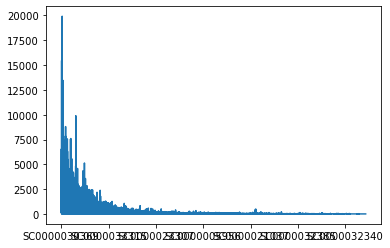

In [11]:
import pandas as pd

interes_series = interest_series.sort_values(ascending=False)
interest_series.plot()

In [12]:
x = interest_series.index
y = interest_series.values
ratio = y/y.sum()
ratio_sum = ratio.cumsum()

for i in range(len(ratio_sum)):
    if ratio_sum[i] > 0.8:
        break;
x = x[:i]
print('전체 관심분야의 80% 종목 수', len(x[:i]))

전체 관심분야의 80% 종목 수 4879


- 전체 32171개의 Attribute 중 4879개 Data가 80%의 이용률을 보임.


- 해당 DataSet으로 차원을 줄여 분석 진행.

#### 3) 4879개 관심 종목에 대한 One-Hot-Encoding

In [13]:
cnt = 0

@ray.remote
def make_list(interest_list):
    global cnt
    tmp = dict(interest_dict[:])
    for e in interest_list:
        try:
            tmp[e] = 1
        except:
            continue
    cnt += 1
    if cnt % 100 == 0:
        print(cnt)
    return list(tmp.values())

In [ ]:
interest_dict = dict()
for e in x[:i]:
    interest_dict[e] = 0
interest_dict = pd.Series(interest_dict)
interest = np.array(ray.get([make_list.remote(interest_list) for interest_list in train['interest_list'].str.split('|')]))

(pid=6124) 100
(pid=15856) 100
(pid=5336) 100
(pid=9500) 100
(pid=8120) 100
(pid=1324) 100
(pid=7676) 100
(pid=8124) 100


2021-10-03 16:45:13,592	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8120, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.41 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.57GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
3476	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
8124	0.19GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
6124	0.1GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.1GiB	C:\Users\

2021-10-03 16:45:15,687	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8120, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.46 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.59GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
8124	0.19GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
3476	0.13GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
6124	0.1GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.1GiB	C:\Users\

2021-10-03 16:45:16,945	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=15856, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.46 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.6GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
8124	0.19GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
3476	0.13GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
6124	0.1GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.1GiB	C:\Users\

2021-10-03 16:45:43,580	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8124, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.42 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.77GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
8124	0.2GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
3476	0.14GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
6124	0.11GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.11GiB	C:\Users

2021-10-03 16:45:46,132	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=9500, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.48 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.77GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
8124	0.2GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
3476	0.14GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
6124	0.11GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.11GiB	C:\Users

2021-10-03 16:45:47,075	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=5336, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.45 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.8GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
8124	0.2GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
3476	0.14GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
6124	0.11GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.11GiB	C:\Users\

2021-10-03 16:45:47,741	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=1324, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.45 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.8GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
8124	0.2GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
3476	0.14GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
6124	0.11GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.11GiB	C:\Users\

(pid=6124) 200
(pid=5336) 200


2021-10-03 16:45:52,317	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8124, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.47 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	2.71GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
3476	0.14GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
8124	0.13GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
6124	0.11GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.11GiB	C:\User

(pid=15856) 200
(pid=1324) 200
(pid=8124) 200
(pid=8120) 200
(pid=9500) 200
(pid=7676) 200


2021-10-03 16:46:00,804	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8120, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.43 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.83GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
8124	0.2GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
3476	0.14GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
6124	0.11GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.11GiB	C:\Users

2021-10-03 16:46:01,497	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=6124, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.43 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.83GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
8124	0.2GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
3476	0.14GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
6124	0.11GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
15856	0.11GiB	C:\Users

2021-10-03 16:46:31,617	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8120, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.42 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.24GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
10432	0.2GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
15920	0.18GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
8124	0.15GiB	C:\User

2021-10-03 16:46:34,710	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=6124, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.44 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.16GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
10432	0.2GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
15920	0.18GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
8124	0.15GiB	C:\User

(pid=6124) 300
(pid=5336) 300


2021-10-03 16:46:47,376	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=6124, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.42 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.3GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.15GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\User

2021-10-03 16:46:50,711	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8124, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.46 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.33GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.15GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

2021-10-03 16:46:52,905	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=5336, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.47 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.37GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.15GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

2021-10-03 16:46:55,967	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8124, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.49 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.4GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
8124	0.15GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe C:\Users\jason\AppData\Roaming\Python\Pytho
10432	0.15GiB	C:\Prog

2021-10-03 16:47:00,134	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=5336, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.53 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.41GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.15GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

2021-10-03 16:47:02,456	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=9500, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.55 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.44GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

2021-10-03 16:47:07,421	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=9500, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.58 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.43GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

(pid=1324) 300


2021-10-03 16:47:08,543	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8120, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.6 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.49GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\User

(pid=15856) 300


2021-10-03 16:47:12,070	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=1324, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.62 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.48GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

(pid=9500) 300


2021-10-03 16:47:12,806	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=8124, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.62 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.49GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

(pid=8120) 300
(pid=7676) 300
(pid=8124) 300
(pid=6124) 400
(pid=5336) 400
(pid=1324) 400
(pid=15856) 400
(pid=8120) 400
(pid=9500) 400
(pid=7676) 400
(pid=8124) 400


2021-10-03 16:47:56,438	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=9500, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.59 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.46GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

2021-10-03 16:47:56,813	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=1324, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.48 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.35GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.15GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

2021-10-03 16:47:57,148	ERROR worker.py:80 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::make_list() (pid=9500, ip=192.168.0.19)
  File "python\ray\_raylet.pyx", line 493, in ray._raylet.execute_task
  File "C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\ray\_private\memory_monitor.py", line 152, in raise_if_low_memory
    self.error_threshold))
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-9JD29NR is used (7.51 / 7.8 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15596	3.41GiB	C:\Users\jason\anaconda3\envs\computer_vision\python.exe -m ipykernel_launcher -f C:\Users\jason\App
15920	0.19GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=renderer --cross-origin-webassemb
3476	0.16GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe
10432	0.15GiB	C:\Program Files (x86)\Google\Chrome\Application\chrome.exe --type=gpu-process --field-trial-handle=
8124	0.15GiB	C:\Use

(pid=6124) 500
(pid=5336) 500
(pid=1324) 500
(pid=15856) 500
(pid=8120) 500
(pid=9500) 500
(pid=7676) 500
(pid=8124) 500
(pid=6124) 600
(pid=5336) 600
(pid=1324) 600


- 4개 Core, 총 8개의 Thread에서 작업이 수행되고 있으나 2분에 5000개로, 150만개를 수행하려면 10시간이나 기다려야 함.


- Data의 수를 줄여주고, Thread에서 발생하는 Local_memory에 대한 할당을 계속 해제해줘도 Memory Error 발생할 가능성 매우 큼.


- 상기의 비생산성으로 인해, 관심 리스트 Data를 One-Hot-Encoding하지 않고, split하였다.


- 가정 : <br>
    1. A|B|C => A, B, C를 고른 것에 대해 독립적.<br><br>
    2. (예시) 2명의 Interest_list가 [[A, B, C], [C, NAN, NAN]]인 경우, [A, C], [B, NaN], [C, NaN]으로 각 Column을 나눈다.<br><br>
    3. NaN의 경우, 문자열 'unselected'로 대치하고 분석을 진행하겠다.<br><br>
    4. 상기의 가정에 따라, 30000개의 column이 추가되지 않고 5개의 column이 추가된다.

#### 4) Interest_list를 가정에 따라 처리

In [14]:
tmp = train['interest_list'].str.split('|', n=5, expand=True).fillna('unselected')
train = pd.concat([train, tmp], axis=1)
train.drop(columns=['interest_list'], inplace=True)
train.head()

,gender,age,slotid,device,connection_type,activity1,activity2,activity3,interest_count,ad_feature1,...,ad_feature3,ad_feature4,click,day,hour,0,1,2,3,4
0,F,41,4b41ff42a99d435,Android,Wifi,15,16,b5531fcacdabf8a,3,cfc9787975528e1,...,433bb4654903b96,edd35ce92deb04a,0,14,13,SC0000030369,SC0000035328,unselected,unselected,unselected
1,M,41,8b20b665760f38f,Android,Unknown,0,28,a3a666eec13ab35,0,c19a753dadc6729,...,3fb304a1e4663c2,26b21127e8ce9f2,0,14,13,,unselected,unselected,unselected,unselected
2,F,20,0e6da441f5f5635,Android,Cellular,371,13,b5531fcacdabf8a,3,73b19689ee73552,...,84121b9d7c43d69,6327ec97866c928,0,14,22,SC0000037306,unselected,unselected,unselected,unselected
3,M,31,8b20b665760f38f,Android,Unknown,2,27,cfb81e6f0919683,0,c19a753dadc6729,...,3fb304a1e4663c2,26b21127e8ce9f2,0,14,6,,unselected,unselected,unselected,unselected
4,M,26,0e6da441f5f5635,Android,Wifi,0,26,cfb81e6f0919683,0,d2a53a5b85838eb,...,07cc82d2ed37a58,3139e75fcb1efb5,0,14,17,,unselected,unselected,unselected,unselected


In [35]:
tmp = test['interest_list'].str.split('|', n=5, expand=True).fillna('unselected')
test = pd.concat([test, tmp], axis=1)
test.drop(columns=['interest_list'], inplace=True)
test.head()

,gender,age,slotid,device,connection_type,activity1,activity2,activity3,interest_count,ad_feature1,ad_feature2,ad_feature3,ad_feature4,day,hour,0,1,2,3,4
index,,,,,,,,,,,,,,,,,,,,
175723,M,20,8b20b665760f38f,iOS,Unknown,10,28,cfb81e6f0919683,0,3152e06bfd31386,43f1b8457ed7583,8117de8f28e18af,de3e8b4dc3c3d92,15,17,,unselected,unselected,unselected,unselected
182582,F,51,4b41ff42a99d435,Android,Cellular,9,16,b5531fcacdabf8a,27,656e6c90dc36602,dea83fdb2b750c4,435d2d5ec098b25,c98ec2baf7480e8,15,17,SC0000016182,SC0000021471,SC0000022956,SC0000025447,SC0000036488
23938,F,41,4b41ff42a99d435,Android,Cellular,0,16,a3a666eec13ab35,6,634918664e0aca0,a695480311c0f4b,87762753d57ce46,1bf861e9779dcab,15,9,SC0000028740,unselected,unselected,unselected,unselected
130434,F,20,8b20b665760f38f,Android,Unknown,8,14,a3a666eec13ab35,0,b9bb2697410a2ba,f8633735ab449ce,8117de8f28e18af,96fd6fae0f481b6,15,20,,unselected,unselected,unselected,unselected
47054,F,41,4b41ff42a99d435,Android,Wifi,1,16,b5531fcacdabf8a,7,5592926128c7d07,ea8d1f8e31efe6c,5eef2cf050b1fe6,403a5a2176dc70d,15,19,SC0000031405,unselected,unselected,unselected,unselected


## 4. 머신러닝 알고리즘 확정

1. 주어진 Data가 One-Hot-Encoding이 되어있지 않으므로, Deep Learning을 활용한 분석은 불가능.
2. Categorical 위주의 Input Data로 이루어져있으므로, CatBoost 머신러닝 알고리즘을 사용하기로 함.
3. Categorical 관련 논문 https://arxiv.org/abs/1706.09516
4. CatBoost는 범주형 데이터에 대한 Encoding이 필요가 없다!

In [15]:
#import tensorflow as tf
#import keras

from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss


from catboost import CatBoostClassifier
from catboost import CatBoost

### 4.1 데이터 분할

In [16]:
train.groupby('click').count()['gender']

click
0    1503599
1      24132
Name: gender, dtype: int64

- 주어진 데이터는 Click에 대한 Class가 0이 훨씬 많은 **불균형 데이터**
- 따라서 **계층화된 K-Fold Cross Validation**을 적용하여 모델을 Training해야 한다.

#### Stratified K-Fold Cross Validation

In [17]:
X = train.drop(columns = ['click'])
y = train['click']
k = 6

skf = StratifiedKFold(n_splits=k,
                      shuffle=True,
                      random_state=42)

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in skf.split(np.zeros(len(y)),y):
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)

### 4.2 학습모델 정의 - 계층화된 K Fold Cross Validation 적용 + CatBoost 모델 구현

#### 1) 평가 척도를 AUC로 두고 Model 학습

- Model 평가에 주로 사용되는 AUROC Curve의 넓이를 나타내는 AUC 지표를 평가 기준으로 사용
- Binary Classification을 확률로 Mapping했을 때의 Log Loss를 최소화하는 방향으로 부스팅 학습
- "부스팅"이기 때문에 맞추지 못했던 부분을 맞추도록 학습하는 데 집중

In [18]:
model_params = {
    'iterations': 120,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'allow_writing_files': False,
    'random_seed': int(time.time()),
    
}
cat_features = [i for i in range(len(X.columns))]
model = CatBoostClassifier(**model_params)

for j in range(k):
            
    x_train = X.loc[list_of_train_index[j], :]
    x_valid = X.loc[list_of_valid_index[j], :]
    
    y_true_train = y[list_of_train_index[j]]
    y_true_valid = y[list_of_valid_index[j]]
    
    model.fit(X=x_train, y=y_true_train,
              eval_set=(x_valid, y_true_valid),
              cat_features=cat_features,
              verbose=True, plot=True, use_best_model = True)
    print('loss_value: ', log_loss(y_true_valid, model.predict_proba(x_valid)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	test: 0.5811254	best: 0.5811254 (0)	total: 2.38s	remaining: 4m 43s
1:	test: 0.6846285	best: 0.6846285 (1)	total: 3.73s	remaining: 3m 40s
2:	test: 0.7836053	best: 0.7836053 (2)	total: 5.1s	remaining: 3m 18s
3:	test: 0.7983637	best: 0.7983637 (3)	total: 6.54s	remaining: 3m 9s
4:	test: 0.8010069	best: 0.8010069 (4)	total: 7.95s	remaining: 3m 2s
5:	test: 0.8063914	best: 0.8063914 (5)	total: 9.1s	remaining: 2m 52s
6:	test: 0.8069074	best: 0.8069074 (6)	total: 10.2s	remaining: 2m 44s
7:	test: 0.8150329	best: 0.8150329 (7)	total: 11.3s	remaining: 2m 38s
8:	test: 0.8156919	best: 0.8156919 (8)	total: 12.4s	remaining: 2m 32s
9:	test: 0.8169350	best: 0.8169350 (9)	total: 13.5s	remaining: 2m 28s
10:	test: 0.8172234	best: 0.8172234 (10)	total: 14.5s	remaining: 2m 24s
11:	test: 0.8172563	best: 0.8172563 (11)	total: 15.6s	remaining: 2m 20s
12:	test: 0.8196118	best: 0.8196118 (12)	total: 16.6s	remaining: 2m 16s
13:	test: 0.8201937	best: 0.8201937 (13)	total: 17.7s	remai

114:	test: 0.8295582	best: 0.8296472 (109)	total: 2m 8s	remaining: 5.6s
115:	test: 0.8295753	best: 0.8296472 (109)	total: 2m 9s	remaining: 4.48s
116:	test: 0.8295777	best: 0.8296472 (109)	total: 2m 11s	remaining: 3.36s
117:	test: 0.8296037	best: 0.8296472 (109)	total: 2m 12s	remaining: 2.24s
118:	test: 0.8295947	best: 0.8296472 (109)	total: 2m 13s	remaining: 1.12s
119:	test: 0.8295785	best: 0.8296472 (109)	total: 2m 14s	remaining: 0us

bestTest = 0.8296472449
bestIteration = 109

Shrink model to first 110 iterations.
loss_value:  0.06763767527196557


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	test: 0.5800312	best: 0.5800312 (0)	total: 1.33s	remaining: 2m 38s
1:	test: 0.6851552	best: 0.6851552 (1)	total: 2.36s	remaining: 2m 19s
2:	test: 0.7851630	best: 0.7851630 (2)	total: 3.5s	remaining: 2m 16s
3:	test: 0.7910578	best: 0.7910578 (3)	total: 4.97s	remaining: 2m 24s
4:	test: 0.8011109	best: 0.8011109 (4)	total: 6.38s	remaining: 2m 26s
5:	test: 0.8028248	best: 0.8028248 (5)	total: 7.04s	remaining: 2m 13s
6:	test: 0.8046704	best: 0.8046704 (6)	total: 8.08s	remaining: 2m 10s
7:	test: 0.8133067	best: 0.8133067 (7)	total: 9.09s	remaining: 2m 7s
8:	test: 0.8139296	best: 0.8139296 (8)	total: 10.1s	remaining: 2m 5s
9:	test: 0.8144028	best: 0.8144028 (9)	total: 11.3s	remaining: 2m 4s
10:	test: 0.8152913	best: 0.8152913 (10)	total: 12.5s	remaining: 2m 3s
11:	test: 0.8154044	best: 0.8154044 (11)	total: 13.6s	remaining: 2m 2s
12:	test: 0.8154730	best: 0.8154730 (12)	total: 14.8s	remaining: 2m 1s
13:	test: 0.8154730	best: 0.8154730 (12)	total: 15.6s	remainin

114:	test: 0.8267234	best: 0.8267234 (114)	total: 2m 13s	remaining: 5.8s
115:	test: 0.8267332	best: 0.8267332 (115)	total: 2m 14s	remaining: 4.64s
116:	test: 0.8267347	best: 0.8267347 (116)	total: 2m 15s	remaining: 3.48s
117:	test: 0.8267226	best: 0.8267347 (116)	total: 2m 16s	remaining: 2.32s
118:	test: 0.8267966	best: 0.8267966 (118)	total: 2m 17s	remaining: 1.16s
119:	test: 0.8267764	best: 0.8267966 (118)	total: 2m 18s	remaining: 0us

bestTest = 0.8267965972
bestIteration = 118

Shrink model to first 119 iterations.
loss_value:  0.06793523316019849


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	test: 0.5853607	best: 0.5853607 (0)	total: 1.37s	remaining: 2m 43s
1:	test: 0.6913970	best: 0.6913970 (1)	total: 2.58s	remaining: 2m 31s
2:	test: 0.7866581	best: 0.7866581 (2)	total: 3.7s	remaining: 2m 24s
3:	test: 0.7964942	best: 0.7964942 (3)	total: 5.06s	remaining: 2m 26s
4:	test: 0.8019049	best: 0.8019049 (4)	total: 6.42s	remaining: 2m 27s
5:	test: 0.8098790	best: 0.8098790 (5)	total: 7.46s	remaining: 2m 21s
6:	test: 0.8102563	best: 0.8102563 (6)	total: 8.67s	remaining: 2m 19s
7:	test: 0.8123535	best: 0.8123535 (7)	total: 9.85s	remaining: 2m 17s
8:	test: 0.8128508	best: 0.8128508 (8)	total: 11s	remaining: 2m 16s
9:	test: 0.8202331	best: 0.8202331 (9)	total: 12.2s	remaining: 2m 13s
10:	test: 0.8207242	best: 0.8207242 (10)	total: 13.3s	remaining: 2m 12s
11:	test: 0.8208498	best: 0.8208498 (11)	total: 14.5s	remaining: 2m 10s
12:	test: 0.8212488	best: 0.8212488 (12)	total: 15.7s	remaining: 2m 9s
13:	test: 0.8214938	best: 0.8214938 (13)	total: 16.8s	remai

115:	test: 0.8317056	best: 0.8317138 (113)	total: 2m 10s	remaining: 4.49s
116:	test: 0.8316944	best: 0.8317138 (113)	total: 2m 11s	remaining: 3.37s
117:	test: 0.8316979	best: 0.8317138 (113)	total: 2m 12s	remaining: 2.25s
118:	test: 0.8316809	best: 0.8317138 (113)	total: 2m 13s	remaining: 1.12s
119:	test: 0.8317137	best: 0.8317138 (113)	total: 2m 14s	remaining: 0us

bestTest = 0.8317138435
bestIteration = 113

Shrink model to first 114 iterations.
loss_value:  0.0676018130367265


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	test: 0.5865984	best: 0.5865984 (0)	total: 1.38s	remaining: 2m 44s
1:	test: 0.6948925	best: 0.6948925 (1)	total: 2.34s	remaining: 2m 18s
2:	test: 0.7937490	best: 0.7937490 (2)	total: 3.44s	remaining: 2m 14s
3:	test: 0.8027256	best: 0.8027256 (3)	total: 4.63s	remaining: 2m 14s
4:	test: 0.8080920	best: 0.8080920 (4)	total: 5.89s	remaining: 2m 15s
5:	test: 0.8170072	best: 0.8170072 (5)	total: 6.95s	remaining: 2m 11s
6:	test: 0.8183248	best: 0.8183248 (6)	total: 8.07s	remaining: 2m 10s
7:	test: 0.8263274	best: 0.8263274 (7)	total: 9.2s	remaining: 2m 8s
8:	test: 0.8281934	best: 0.8281934 (8)	total: 10.4s	remaining: 2m 8s
9:	test: 0.8289068	best: 0.8289068 (9)	total: 11.6s	remaining: 2m 7s
10:	test: 0.8294864	best: 0.8294864 (10)	total: 12.8s	remaining: 2m 7s
11:	test: 0.8296277	best: 0.8296277 (11)	total: 14s	remaining: 2m 6s
12:	test: 0.8299098	best: 0.8299098 (12)	total: 15.2s	remaining: 2m 4s
13:	test: 0.8301671	best: 0.8301671 (13)	total: 16.3s	remaining:

115:	test: 0.8391509	best: 0.8392574 (91)	total: 2m 9s	remaining: 4.45s
116:	test: 0.8391509	best: 0.8392574 (91)	total: 2m 10s	remaining: 3.34s
117:	test: 0.8391185	best: 0.8392574 (91)	total: 2m 11s	remaining: 2.23s
118:	test: 0.8391269	best: 0.8392574 (91)	total: 2m 12s	remaining: 1.11s
119:	test: 0.8390728	best: 0.8392574 (91)	total: 2m 13s	remaining: 0us

bestTest = 0.839257446
bestIteration = 91

Shrink model to first 92 iterations.
loss_value:  0.06508043212781163


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	test: 0.5853825	best: 0.5853825 (0)	total: 1.34s	remaining: 2m 39s
1:	test: 0.6913974	best: 0.6913974 (1)	total: 2.51s	remaining: 2m 28s
2:	test: 0.7912936	best: 0.7912936 (2)	total: 3.76s	remaining: 2m 26s
3:	test: 0.8044486	best: 0.8044486 (3)	total: 5.1s	remaining: 2m 27s
4:	test: 0.8064794	best: 0.8064794 (4)	total: 6.48s	remaining: 2m 29s
5:	test: 0.8087162	best: 0.8087162 (5)	total: 7.35s	remaining: 2m 19s
6:	test: 0.8091222	best: 0.8091222 (6)	total: 8.43s	remaining: 2m 16s
7:	test: 0.8130260	best: 0.8130260 (7)	total: 9.66s	remaining: 2m 15s
8:	test: 0.8213988	best: 0.8213988 (8)	total: 10.7s	remaining: 2m 12s
9:	test: 0.8217146	best: 0.8217146 (9)	total: 11.8s	remaining: 2m 9s
10:	test: 0.8222367	best: 0.8222367 (10)	total: 13s	remaining: 2m 8s
11:	test: 0.8226419	best: 0.8226419 (11)	total: 14.2s	remaining: 2m 7s
12:	test: 0.8246164	best: 0.8246164 (12)	total: 15.3s	remaining: 2m 5s
13:	test: 0.8248970	best: 0.8248970 (13)	total: 16.5s	remainin

115:	test: 0.8313353	best: 0.8313353 (115)	total: 2m 8s	remaining: 4.42s
116:	test: 0.8313395	best: 0.8313395 (116)	total: 2m 9s	remaining: 3.31s
117:	test: 0.8313200	best: 0.8313395 (116)	total: 2m 10s	remaining: 2.21s
118:	test: 0.8313205	best: 0.8313395 (116)	total: 2m 11s	remaining: 1.1s
119:	test: 0.8313205	best: 0.8313395 (116)	total: 2m 12s	remaining: 0us

bestTest = 0.831339474
bestIteration = 116

Shrink model to first 117 iterations.
loss_value:  0.065364230781416


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	test: 0.6077701	best: 0.6077701 (0)	total: 1.63s	remaining: 3m 13s
1:	test: 0.6765349	best: 0.6765349 (1)	total: 2.85s	remaining: 2m 48s
2:	test: 0.7824015	best: 0.7824015 (2)	total: 3.88s	remaining: 2m 31s
3:	test: 0.7872026	best: 0.7872026 (3)	total: 4.78s	remaining: 2m 18s
4:	test: 0.8014925	best: 0.8014925 (4)	total: 5.88s	remaining: 2m 15s
5:	test: 0.8038904	best: 0.8038904 (5)	total: 6.9s	remaining: 2m 11s
6:	test: 0.8112992	best: 0.8112992 (6)	total: 8.24s	remaining: 2m 13s
7:	test: 0.8124472	best: 0.8124472 (7)	total: 9.43s	remaining: 2m 11s
8:	test: 0.8137361	best: 0.8137361 (8)	total: 10.7s	remaining: 2m 11s
9:	test: 0.8203680	best: 0.8203680 (9)	total: 11.8s	remaining: 2m 10s
10:	test: 0.8210023	best: 0.8210023 (10)	total: 13s	remaining: 2m 9s
11:	test: 0.8212970	best: 0.8212970 (11)	total: 14.2s	remaining: 2m 7s
12:	test: 0.8213692	best: 0.8213692 (12)	total: 15.3s	remaining: 2m 6s
13:	test: 0.8239004	best: 0.8239004 (13)	total: 16.5s	remaini

114:	test: 0.8306870	best: 0.8306870 (114)	total: 2m 16s	remaining: 5.92s
115:	test: 0.8306800	best: 0.8306870 (114)	total: 2m 17s	remaining: 4.74s
116:	test: 0.8306533	best: 0.8306870 (114)	total: 2m 18s	remaining: 3.55s
117:	test: 0.8306654	best: 0.8306870 (114)	total: 2m 19s	remaining: 2.37s
118:	test: 0.8306805	best: 0.8306870 (114)	total: 2m 20s	remaining: 1.18s
119:	test: 0.8306877	best: 0.8306877 (119)	total: 2m 21s	remaining: 0us

bestTest = 0.8306876981
bestIteration = 119

loss_value:  0.06607829480992042


> AUROC 커브의 넓이가 1에 가까워질 수록 좋은데 0.85를 넘지 못함. <br><br> **Binary Classification** 상황에서 과연 좋은 결과인가? <br> -> **No**

#### 2) 평가 척도를 F1 - Score로 두고 Model 학습

- 본 데이터가 불균형 데이터이기 때문에 F1-Score가 매우 유의미할 것이라고 생각.
- F1 Score는 Recall과 Precise의 조화평균
- Type 1 Error와 Type 2 Error를 줄이는 방향으로 학습 진행될 것으로 기대

In [19]:
model_params = {
    'iterations': 120,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'allow_writing_files': False,
    'random_seed': int(time.time()),
    
}
cat_features = [i for i in range(len(X.columns))]
model = CatBoostClassifier(**model_params)

for j in range(k):
            
    x_train = X.loc[list_of_train_index[j], :]
    x_valid = X.loc[list_of_valid_index[j], :]
    
    y_true_train = y[list_of_train_index[j]]
    y_true_valid = y[list_of_valid_index[j]]
    
    model.fit(X=x_train, y=y_true_train,
              eval_set=(x_valid, y_true_valid),
              cat_features=cat_features,
              verbose=True, plot=True, use_best_model = True)
    print('loss_value: ', log_loss(y_true_valid, model.predict_proba(x_valid)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 829ms	remaining: 1m 38s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.11s	remaining: 2m 4s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.42s	remaining: 2m 13s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 4.26s	remaining: 2m 3s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5.47s	remaining: 2m 5s
5:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.49s	remaining: 2m 3s
6:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 7.49s	remaining: 2m
7:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 8.62s	remaining: 2m
8:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 9.81s	remaining: 2m 1s
9:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 11s	remaining: 2m
10:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 12.1s	remaining: 1m 59s
11:	learn: 0.0000000	test: 0.000

94:	learn: 0.0084146	test: 0.0000000	best: 0.0004969 (76)	total: 1m 42s	remaining: 27.1s
95:	learn: 0.0088093	test: 0.0000000	best: 0.0004969 (76)	total: 1m 44s	remaining: 26s
96:	learn: 0.0088093	test: 0.0000000	best: 0.0004969 (76)	total: 1m 45s	remaining: 24.9s
97:	learn: 0.0088097	test: 0.0000000	best: 0.0004969 (76)	total: 1m 46s	remaining: 23.8s
98:	learn: 0.0088097	test: 0.0000000	best: 0.0004969 (76)	total: 1m 47s	remaining: 22.8s
99:	learn: 0.0088097	test: 0.0000000	best: 0.0004969 (76)	total: 1m 48s	remaining: 21.7s
100:	learn: 0.0087107	test: 0.0000000	best: 0.0004969 (76)	total: 1m 49s	remaining: 20.6s
101:	learn: 0.0088093	test: 0.0000000	best: 0.0004969 (76)	total: 1m 50s	remaining: 19.5s
102:	learn: 0.0094988	test: 0.0000000	best: 0.0004969 (76)	total: 1m 51s	remaining: 18.4s
103:	learn: 0.0095973	test: 0.0000000	best: 0.0004969 (76)	total: 1m 52s	remaining: 17.3s
104:	learn: 0.0097947	test: 0.0000000	best: 0.0004969 (76)	total: 1m 53s	remaining: 16.3s
105:	learn: 0.0098

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.5s	remaining: 2m 58s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.67s	remaining: 2m 37s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.97s	remaining: 2m 34s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5.08s	remaining: 2m 27s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.32s	remaining: 2m 25s
5:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 7.39s	remaining: 2m 20s
6:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 8.41s	remaining: 2m 15s
7:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 9.56s	remaining: 2m 13s
8:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 10.7s	remaining: 2m 12s
9:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 11.9s	remaining: 2m 11s
10:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 13s	remaining: 2m 9s
11:	learn: 0.0000

94:	learn: 0.0092991	test: 0.0000000	best: 0.0000000 (0)	total: 1m 44s	remaining: 27.5s
95:	learn: 0.0091031	test: 0.0000000	best: 0.0000000 (0)	total: 1m 45s	remaining: 26.4s
96:	learn: 0.0088075	test: 0.0000000	best: 0.0000000 (0)	total: 1m 46s	remaining: 25.3s
97:	learn: 0.0092015	test: 0.0000000	best: 0.0000000 (0)	total: 1m 47s	remaining: 24.2s
98:	learn: 0.0094970	test: 0.0000000	best: 0.0000000 (0)	total: 1m 48s	remaining: 23.1s
99:	learn: 0.0094974	test: 0.0000000	best: 0.0000000 (0)	total: 1m 50s	remaining: 22s
100:	learn: 0.0097928	test: 0.0000000	best: 0.0000000 (0)	total: 1m 51s	remaining: 20.9s
101:	learn: 0.0097923	test: 0.0000000	best: 0.0000000 (0)	total: 1m 52s	remaining: 19.8s
102:	learn: 0.0106772	test: 0.0000000	best: 0.0000000 (0)	total: 1m 53s	remaining: 18.7s
103:	learn: 0.0106772	test: 0.0000000	best: 0.0000000 (0)	total: 1m 54s	remaining: 17.6s
104:	learn: 0.0107755	test: 0.0000000	best: 0.0000000 (0)	total: 1m 55s	remaining: 16.5s
105:	learn: 0.0109722	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 939ms	remaining: 1m 51s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.22s	remaining: 2m 10s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.75s	remaining: 2m 26s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 4.85s	remaining: 2m 20s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.08s	remaining: 2m 19s
5:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 7.46s	remaining: 2m 21s
6:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 8.58s	remaining: 2m 18s
7:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 9.74s	remaining: 2m 16s
8:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 10.9s	remaining: 2m 14s
9:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 12.1s	remaining: 2m 13s
10:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 13.2s	remaining: 2m 10s
11:	learn: 0.

94:	learn: 0.0130364	test: 0.0000000	best: 0.0000000 (0)	total: 1m 51s	remaining: 29.4s
95:	learn: 0.0128401	test: 0.0000000	best: 0.0000000 (0)	total: 1m 53s	remaining: 28.3s
96:	learn: 0.0128401	test: 0.0000000	best: 0.0000000 (0)	total: 1m 54s	remaining: 27.1s
97:	learn: 0.0131332	test: 0.0000000	best: 0.0000000 (0)	total: 1m 55s	remaining: 25.9s
98:	learn: 0.0132320	test: 0.0000000	best: 0.0000000 (0)	total: 1m 56s	remaining: 24.7s
99:	learn: 0.0131339	test: 0.0000000	best: 0.0000000 (0)	total: 1m 57s	remaining: 23.5s
100:	learn: 0.0131339	test: 0.0000000	best: 0.0000000 (0)	total: 1m 58s	remaining: 22.3s
101:	learn: 0.0126426	test: 0.0000000	best: 0.0000000 (0)	total: 1m 59s	remaining: 21.1s
102:	learn: 0.0127407	test: 0.0000000	best: 0.0000000 (0)	total: 2m	remaining: 20s
103:	learn: 0.0127407	test: 0.0000000	best: 0.0000000 (0)	total: 2m 1s	remaining: 18.8s
104:	learn: 0.0127420	test: 0.0000000	best: 0.0000000 (0)	total: 2m 3s	remaining: 17.6s
105:	learn: 0.0131352	test: 0.00000

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.02s	remaining: 2m 1s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.19s	remaining: 2m 9s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.69s	remaining: 2m 24s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 4.55s	remaining: 2m 12s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5.75s	remaining: 2m 12s
5:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.83s	remaining: 2m 9s
6:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 7.93s	remaining: 2m 8s
7:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 9.09s	remaining: 2m 7s
8:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 10.3s	remaining: 2m 6s
9:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 11.3s	remaining: 2m 4s
10:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 12.4s	remaining: 2m 3s
11:	learn: 0.0000000	

94:	learn: 0.0089069	test: 0.0000000	best: 0.0004970 (80)	total: 1m 51s	remaining: 29.3s
95:	learn: 0.0091040	test: 0.0000000	best: 0.0004970 (80)	total: 1m 52s	remaining: 28.1s
96:	learn: 0.0092025	test: 0.0000000	best: 0.0004970 (80)	total: 1m 53s	remaining: 26.9s
97:	learn: 0.0094974	test: 0.0000000	best: 0.0004970 (80)	total: 1m 54s	remaining: 25.7s
98:	learn: 0.0097933	test: 0.0004970	best: 0.0004970 (80)	total: 1m 55s	remaining: 24.6s
99:	learn: 0.0093014	test: 0.0000000	best: 0.0004970 (80)	total: 1m 56s	remaining: 23.4s
100:	learn: 0.0094004	test: 0.0000000	best: 0.0004970 (80)	total: 1m 57s	remaining: 22.2s
101:	learn: 0.0096958	test: 0.0004968	best: 0.0004970 (80)	total: 1m 59s	remaining: 21s
102:	learn: 0.0098912	test: 0.0000000	best: 0.0004970 (80)	total: 2m	remaining: 19.8s
103:	learn: 0.0096948	test: 0.0000000	best: 0.0004970 (80)	total: 2m 1s	remaining: 18.7s
104:	learn: 0.0093994	test: 0.0000000	best: 0.0004970 (80)	total: 2m 2s	remaining: 17.5s
105:	learn: 0.0094974	te

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 755ms	remaining: 1m 29s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.02s	remaining: 1m 59s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.48s	remaining: 2m 15s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 4.64s	remaining: 2m 14s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5.88s	remaining: 2m 15s
5:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 7.02s	remaining: 2m 13s
6:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 8.1s	remaining: 2m 10s
7:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 9.3s	remaining: 2m 10s
8:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 10.4s	remaining: 2m 8s
9:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 11.4s	remaining: 2m 5s
10:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 12.5s	remaining: 2m 4s
11:	learn: 0.00000

93:	learn: 0.0085149	test: 0.0009926	best: 0.0014903 (59)	total: 1m 44s	remaining: 28.8s
94:	learn: 0.0084163	test: 0.0009928	best: 0.0014903 (59)	total: 1m 45s	remaining: 27.6s
95:	learn: 0.0084167	test: 0.0009926	best: 0.0014903 (59)	total: 1m 46s	remaining: 26.5s
96:	learn: 0.0086134	test: 0.0009923	best: 0.0014903 (59)	total: 1m 47s	remaining: 25.4s
97:	learn: 0.0088106	test: 0.0009928	best: 0.0014903 (59)	total: 1m 48s	remaining: 24.3s
98:	learn: 0.0089096	test: 0.0009928	best: 0.0014903 (59)	total: 1m 49s	remaining: 23.2s
99:	learn: 0.0090081	test: 0.0009928	best: 0.0014903 (59)	total: 1m 50s	remaining: 22.1s
100:	learn: 0.0091067	test: 0.0009928	best: 0.0014903 (59)	total: 1m 51s	remaining: 21s
101:	learn: 0.0092052	test: 0.0009928	best: 0.0014903 (59)	total: 1m 52s	remaining: 19.9s
102:	learn: 0.0092052	test: 0.0009928	best: 0.0014903 (59)	total: 1m 53s	remaining: 18.8s
103:	learn: 0.0094998	test: 0.0009926	best: 0.0014903 (59)	total: 1m 54s	remaining: 17.7s
104:	learn: 0.00979

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.22s	remaining: 2m 25s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.9s	remaining: 1m 52s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.07s	remaining: 1m 59s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 4.03s	remaining: 1m 56s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5.28s	remaining: 2m 1s
5:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.31s	remaining: 1m 59s
6:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 7.3s	remaining: 1m 57s
7:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 8.54s	remaining: 1m 59s
8:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 9.73s	remaining: 2m
9:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 10.9s	remaining: 2m
10:	learn: 0.0001989	test: 0.0000000	best: 0.0000000 (0)	total: 12.1s	remaining: 1m 59s
11:	learn: 0.0000994	tes

94:	learn: 0.0077235	test: 0.0000000	best: 0.0004969 (81)	total: 1m 44s	remaining: 27.5s
95:	learn: 0.0074279	test: 0.0004968	best: 0.0004969 (81)	total: 1m 45s	remaining: 26.4s
96:	learn: 0.0080194	test: 0.0000000	best: 0.0004969 (81)	total: 1m 46s	remaining: 25.3s
97:	learn: 0.0083152	test: 0.0000000	best: 0.0004969 (81)	total: 1m 47s	remaining: 24.2s
98:	learn: 0.0086113	test: 0.0000000	best: 0.0004969 (81)	total: 1m 48s	remaining: 23.1s
99:	learn: 0.0090072	test: 0.0004966	best: 0.0004969 (81)	total: 1m 49s	remaining: 22s
100:	learn: 0.0092038	test: 0.0004966	best: 0.0004969 (81)	total: 1m 50s	remaining: 20.9s
101:	learn: 0.0094013	test: 0.0004964	best: 0.0004969 (81)	total: 1m 52s	remaining: 19.8s
102:	learn: 0.0094013	test: 0.0004964	best: 0.0004969 (81)	total: 1m 53s	remaining: 18.7s
103:	learn: 0.0093009	test: 0.0004964	best: 0.0004969 (81)	total: 1m 54s	remaining: 17.6s
104:	learn: 0.0093999	test: 0.0004964	best: 0.0004969 (81)	total: 1m 55s	remaining: 16.5s
105:	learn: 0.0093

> F1 Score는 1에 가까울 수록 불균형 Data에 대한 일반화 척도가 높아지고, 0에 가까울수록 그 성능이 떨어짐.<br><br>**본 학습모델에 대한 F1-Score 결과가 매우 불량.**

#### 3) 본 과제의 의도에 맞게 eval_metric을 LogLoss로 두고 학습 진행

In [20]:
model_params = {
    'iterations': 120,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'allow_writing_files': False,
    'random_seed': int(time.time()),
    
}
cat_features = [i for i in range(len(X.columns))]
model = CatBoostClassifier(**model_params)

for j in range(k):
            
    x_train = X.loc[list_of_train_index[j], :]
    x_valid = X.loc[list_of_valid_index[j], :]
    
    y_true_train = y[list_of_train_index[j]]
    y_true_valid = y[list_of_valid_index[j]]
    
    model.fit(X=x_train, y
              =y_true_train,
              eval_set=(x_valid, y_true_valid),
              cat_features=cat_features,
              verbose=True, plot=True, use_best_model = True)
    print('loss_value: ', log_loss(y_true_valid, model.predict_proba(x_valid)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.1665249	test: 0.1665248	best: 0.1665248 (0)	total: 823ms	remaining: 1m 37s
1:	learn: 0.0906927	test: 0.0908528	best: 0.0908528 (1)	total: 2.35s	remaining: 2m 18s
2:	learn: 0.0748446	test: 0.0750525	best: 0.0750525 (2)	total: 3.52s	remaining: 2m 17s
3:	learn: 0.0712859	test: 0.0716217	best: 0.0716217 (3)	total: 4.67s	remaining: 2m 15s
4:	learn: 0.0701361	test: 0.0705131	best: 0.0705131 (4)	total: 5.96s	remaining: 2m 16s
5:	learn: 0.0692947	test: 0.0696965	best: 0.0696965 (5)	total: 11.4s	remaining: 3m 36s
6:	learn: 0.0690832	test: 0.0695019	best: 0.0695019 (6)	total: 12.5s	remaining: 3m 22s
7:	learn: 0.0684243	test: 0.0688236	best: 0.0688236 (7)	total: 13.7s	remaining: 3m 12s
8:	learn: 0.0683078	test: 0.0687219	best: 0.0687219 (8)	total: 14.9s	remaining: 3m 3s
9:	learn: 0.0682110	test: 0.0686202	best: 0.0686202 (9)	total: 16s	remaining: 2m 55s
10:	learn: 0.0681212	test: 0.0685121	best: 0.0685121 (10)	total: 17.2s	remaining: 2m 50s
11:	learn: 0.06

93:	learn: 0.0664848	test: 0.0677465	best: 0.0677401 (79)	total: 1m 46s	remaining: 29.4s
94:	learn: 0.0664757	test: 0.0677429	best: 0.0677401 (79)	total: 1m 47s	remaining: 28.3s
95:	learn: 0.0664757	test: 0.0677429	best: 0.0677401 (79)	total: 1m 48s	remaining: 27.1s
96:	learn: 0.0664751	test: 0.0677423	best: 0.0677401 (79)	total: 1m 49s	remaining: 26s
97:	learn: 0.0664644	test: 0.0677383	best: 0.0677383 (97)	total: 1m 50s	remaining: 24.9s
98:	learn: 0.0664561	test: 0.0677391	best: 0.0677383 (97)	total: 1m 51s	remaining: 23.7s
99:	learn: 0.0664422	test: 0.0677453	best: 0.0677383 (97)	total: 1m 52s	remaining: 22.6s
100:	learn: 0.0664331	test: 0.0677440	best: 0.0677383 (97)	total: 1m 54s	remaining: 21.5s
101:	learn: 0.0664211	test: 0.0677488	best: 0.0677383 (97)	total: 1m 55s	remaining: 20.3s
102:	learn: 0.0664125	test: 0.0677477	best: 0.0677383 (97)	total: 1m 56s	remaining: 19.2s
103:	learn: 0.0664053	test: 0.0677457	best: 0.0677383 (97)	total: 1m 57s	remaining: 18s
104:	learn: 0.0663974

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.1665249	test: 0.1665248	best: 0.1665248 (0)	total: 1.3s	remaining: 2m 35s
1:	learn: 0.0906935	test: 0.0908050	best: 0.0908050 (1)	total: 3.84s	remaining: 3m 46s
2:	learn: 0.0757127	test: 0.0758512	best: 0.0758512 (2)	total: 4.88s	remaining: 3m 10s
3:	learn: 0.0713322	test: 0.0715680	best: 0.0715680 (3)	total: 6.13s	remaining: 2m 57s
4:	learn: 0.0700969	test: 0.0704487	best: 0.0704487 (4)	total: 7.32s	remaining: 2m 48s
5:	learn: 0.0692725	test: 0.0696849	best: 0.0696849 (5)	total: 8.51s	remaining: 2m 41s
6:	learn: 0.0690468	test: 0.0695141	best: 0.0695141 (6)	total: 9.62s	remaining: 2m 35s
7:	learn: 0.0684341	test: 0.0689049	best: 0.0689049 (7)	total: 10.8s	remaining: 2m 30s
8:	learn: 0.0682624	test: 0.0687383	best: 0.0687383 (8)	total: 12.1s	remaining: 2m 29s
9:	learn: 0.0681150	test: 0.0686227	best: 0.0686227 (9)	total: 13.4s	remaining: 2m 26s
10:	learn: 0.0679930	test: 0.0685390	best: 0.0685390 (10)	total: 14.5s	remaining: 2m 23s
11:	learn: 0.

93:	learn: 0.0664654	test: 0.0679797	best: 0.0679383 (78)	total: 1m 45s	remaining: 29.1s
94:	learn: 0.0664544	test: 0.0679806	best: 0.0679383 (78)	total: 1m 46s	remaining: 28s
95:	learn: 0.0664437	test: 0.0680059	best: 0.0679383 (78)	total: 1m 47s	remaining: 26.9s
96:	learn: 0.0664340	test: 0.0680106	best: 0.0679383 (78)	total: 1m 48s	remaining: 25.7s
97:	learn: 0.0664329	test: 0.0680109	best: 0.0679383 (78)	total: 1m 49s	remaining: 24.6s
98:	learn: 0.0664326	test: 0.0680110	best: 0.0679383 (78)	total: 1m 50s	remaining: 23.5s
99:	learn: 0.0664245	test: 0.0680118	best: 0.0679383 (78)	total: 1m 51s	remaining: 22.4s
100:	learn: 0.0664062	test: 0.0680114	best: 0.0679383 (78)	total: 1m 52s	remaining: 21.2s
101:	learn: 0.0663207	test: 0.0679290	best: 0.0679290 (101)	total: 1m 54s	remaining: 20.1s
102:	learn: 0.0663105	test: 0.0679303	best: 0.0679290 (101)	total: 1m 55s	remaining: 19s
103:	learn: 0.0662966	test: 0.0679293	best: 0.0679290 (101)	total: 1m 56s	remaining: 17.9s
104:	learn: 0.0662

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.1665249	test: 0.1665248	best: 0.1665248 (0)	total: 818ms	remaining: 1m 37s
1:	learn: 0.0907529	test: 0.0907507	best: 0.0907507 (1)	total: 2.28s	remaining: 2m 14s
2:	learn: 0.0745661	test: 0.0746543	best: 0.0746543 (2)	total: 3.31s	remaining: 2m 9s
3:	learn: 0.0713798	test: 0.0714718	best: 0.0714718 (3)	total: 4.3s	remaining: 2m 4s
4:	learn: 0.0698506	test: 0.0700250	best: 0.0700250 (4)	total: 5.51s	remaining: 2m 6s
5:	learn: 0.0692006	test: 0.0694019	best: 0.0694019 (5)	total: 6.49s	remaining: 2m 3s
6:	learn: 0.0690574	test: 0.0692630	best: 0.0692630 (6)	total: 7.45s	remaining: 2m
7:	learn: 0.0688977	test: 0.0690753	best: 0.0690753 (7)	total: 8.58s	remaining: 2m
8:	learn: 0.0687764	test: 0.0689743	best: 0.0689743 (8)	total: 9.77s	remaining: 2m
9:	learn: 0.0682495	test: 0.0684291	best: 0.0684291 (9)	total: 11s	remaining: 2m
10:	learn: 0.0681677	test: 0.0683320	best: 0.0683320 (10)	total: 12.1s	remaining: 2m
11:	learn: 0.0681218	test: 0.0683021	be

93:	learn: 0.0665149	test: 0.0674433	best: 0.0674216 (85)	total: 1m 42s	remaining: 28.3s
94:	learn: 0.0665116	test: 0.0674416	best: 0.0674216 (85)	total: 1m 43s	remaining: 27.2s
95:	learn: 0.0665042	test: 0.0674415	best: 0.0674216 (85)	total: 1m 44s	remaining: 26.2s
96:	learn: 0.0664875	test: 0.0674485	best: 0.0674216 (85)	total: 1m 45s	remaining: 25.1s
97:	learn: 0.0664809	test: 0.0674497	best: 0.0674216 (85)	total: 1m 46s	remaining: 24s
98:	learn: 0.0664799	test: 0.0674509	best: 0.0674216 (85)	total: 1m 47s	remaining: 22.9s
99:	learn: 0.0664706	test: 0.0674537	best: 0.0674216 (85)	total: 1m 48s	remaining: 21.8s
100:	learn: 0.0664610	test: 0.0674533	best: 0.0674216 (85)	total: 1m 50s	remaining: 20.7s
101:	learn: 0.0664508	test: 0.0674593	best: 0.0674216 (85)	total: 1m 51s	remaining: 19.6s
102:	learn: 0.0664364	test: 0.0674553	best: 0.0674216 (85)	total: 1m 52s	remaining: 18.5s
103:	learn: 0.0664298	test: 0.0674606	best: 0.0674216 (85)	total: 1m 53s	remaining: 17.4s
104:	learn: 0.06642

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.1665249	test: 0.1665248	best: 0.1665248 (0)	total: 916ms	remaining: 1m 49s
1:	learn: 0.0908310	test: 0.0906730	best: 0.0906730 (1)	total: 2.48s	remaining: 2m 26s
2:	learn: 0.0749899	test: 0.0745347	best: 0.0745347 (2)	total: 3.82s	remaining: 2m 28s
3:	learn: 0.0713433	test: 0.0708864	best: 0.0708864 (3)	total: 4.89s	remaining: 2m 21s
4:	learn: 0.0699252	test: 0.0693816	best: 0.0693816 (4)	total: 6.17s	remaining: 2m 21s
5:	learn: 0.0693775	test: 0.0688443	best: 0.0688443 (5)	total: 7.27s	remaining: 2m 18s
6:	learn: 0.0686980	test: 0.0681170	best: 0.0681170 (6)	total: 8.38s	remaining: 2m 15s
7:	learn: 0.0685447	test: 0.0679419	best: 0.0679419 (7)	total: 9.47s	remaining: 2m 12s
8:	learn: 0.0684180	test: 0.0677975	best: 0.0677975 (8)	total: 10.7s	remaining: 2m 11s
9:	learn: 0.0683322	test: 0.0677072	best: 0.0677072 (9)	total: 11.8s	remaining: 2m 9s
10:	learn: 0.0682604	test: 0.0676428	best: 0.0676428 (10)	total: 12.9s	remaining: 2m 7s
11:	learn: 0.0

93:	learn: 0.0665884	test: 0.0668616	best: 0.0668539 (86)	total: 1m 50s	remaining: 30.6s
94:	learn: 0.0665860	test: 0.0668628	best: 0.0668539 (86)	total: 1m 51s	remaining: 29.4s
95:	learn: 0.0665749	test: 0.0668605	best: 0.0668539 (86)	total: 1m 52s	remaining: 28.2s
96:	learn: 0.0665738	test: 0.0668622	best: 0.0668539 (86)	total: 1m 54s	remaining: 27s
97:	learn: 0.0665638	test: 0.0668668	best: 0.0668539 (86)	total: 1m 55s	remaining: 25.9s
98:	learn: 0.0665493	test: 0.0668712	best: 0.0668539 (86)	total: 1m 56s	remaining: 24.7s
99:	learn: 0.0665410	test: 0.0668729	best: 0.0668539 (86)	total: 1m 57s	remaining: 23.5s
100:	learn: 0.0665349	test: 0.0668703	best: 0.0668539 (86)	total: 1m 58s	remaining: 22.3s
101:	learn: 0.0665260	test: 0.0668715	best: 0.0668539 (86)	total: 1m 59s	remaining: 21.1s
102:	learn: 0.0665134	test: 0.0668693	best: 0.0668539 (86)	total: 2m	remaining: 19.9s
103:	learn: 0.0665026	test: 0.0668684	best: 0.0668539 (86)	total: 2m 1s	remaining: 18.7s
104:	learn: 0.0664926	te

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.1665249	test: 0.1665248	best: 0.1665248 (0)	total: 778ms	remaining: 1m 32s
1:	learn: 0.0907908	test: 0.0907219	best: 0.0907219 (1)	total: 2.51s	remaining: 2m 28s
2:	learn: 0.0746819	test: 0.0743863	best: 0.0743863 (2)	total: 3.59s	remaining: 2m 19s
3:	learn: 0.0714599	test: 0.0710621	best: 0.0710621 (3)	total: 4.57s	remaining: 2m 12s
4:	learn: 0.0700864	test: 0.0695959	best: 0.0695959 (4)	total: 5.75s	remaining: 2m 12s
5:	learn: 0.0695185	test: 0.0690028	best: 0.0690028 (5)	total: 7.07s	remaining: 2m 14s
6:	learn: 0.0692376	test: 0.0686763	best: 0.0686763 (6)	total: 8.31s	remaining: 2m 14s
7:	learn: 0.0690489	test: 0.0684881	best: 0.0684881 (7)	total: 9.48s	remaining: 2m 12s
8:	learn: 0.0688965	test: 0.0683493	best: 0.0683493 (8)	total: 10.6s	remaining: 2m 10s
9:	learn: 0.0684157	test: 0.0679017	best: 0.0679017 (9)	total: 11.6s	remaining: 2m 7s
10:	learn: 0.0683387	test: 0.0678051	best: 0.0678051 (10)	total: 12.8s	remaining: 2m 6s
11:	learn: 0.0

93:	learn: 0.0665525	test: 0.0670298	best: 0.0670060 (83)	total: 1m 43s	remaining: 28.6s
94:	learn: 0.0665440	test: 0.0670322	best: 0.0670060 (83)	total: 1m 44s	remaining: 27.5s
95:	learn: 0.0665382	test: 0.0670320	best: 0.0670060 (83)	total: 1m 45s	remaining: 26.4s
96:	learn: 0.0665269	test: 0.0670335	best: 0.0670060 (83)	total: 1m 46s	remaining: 25.3s
97:	learn: 0.0665190	test: 0.0670378	best: 0.0670060 (83)	total: 1m 47s	remaining: 24.2s
98:	learn: 0.0665122	test: 0.0670378	best: 0.0670060 (83)	total: 1m 48s	remaining: 23.1s
99:	learn: 0.0665061	test: 0.0670407	best: 0.0670060 (83)	total: 1m 49s	remaining: 22s
100:	learn: 0.0664991	test: 0.0670405	best: 0.0670060 (83)	total: 1m 50s	remaining: 20.9s
101:	learn: 0.0664991	test: 0.0670410	best: 0.0670060 (83)	total: 1m 51s	remaining: 19.8s
102:	learn: 0.0664893	test: 0.0670492	best: 0.0670060 (83)	total: 1m 52s	remaining: 18.6s
103:	learn: 0.0664851	test: 0.0670531	best: 0.0670060 (83)	total: 1m 54s	remaining: 17.5s
104:	learn: 0.06647

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.46598
0:	learn: 0.1665248	test: 0.1665249	best: 0.1665249 (0)	total: 760ms	remaining: 1m 30s
1:	learn: 0.0974888	test: 0.0974895	best: 0.0974895 (1)	total: 1.52s	remaining: 1m 29s
2:	learn: 0.0760651	test: 0.0760274	best: 0.0760274 (2)	total: 2.56s	remaining: 1m 39s
3:	learn: 0.0716154	test: 0.0714879	best: 0.0714879 (3)	total: 3.83s	remaining: 1m 51s
4:	learn: 0.0704736	test: 0.0703142	best: 0.0703142 (4)	total: 4.85s	remaining: 1m 51s
5:	learn: 0.0696305	test: 0.0695298	best: 0.0695298 (5)	total: 5.87s	remaining: 1m 51s
6:	learn: 0.0693644	test: 0.0693094	best: 0.0693094 (6)	total: 6.87s	remaining: 1m 50s
7:	learn: 0.0690949	test: 0.0690715	best: 0.0690715 (7)	total: 7.98s	remaining: 1m 51s
8:	learn: 0.0689285	test: 0.0689241	best: 0.0689241 (8)	total: 9.15s	remaining: 1m 52s
9:	learn: 0.0683996	test: 0.0684671	best: 0.0684671 (9)	total: 10.3s	remaining: 1m 53s
10:	learn: 0.0683255	test: 0.0683974	best: 0.0683974 (10)	total: 11.5s	remaining: 1m 53s
11:	learn: 0

93:	learn: 0.0665984	test: 0.0676324	best: 0.0675940 (83)	total: 1m 42s	remaining: 28.4s
94:	learn: 0.0665910	test: 0.0676362	best: 0.0675940 (83)	total: 1m 43s	remaining: 27.3s
95:	learn: 0.0665790	test: 0.0676368	best: 0.0675940 (83)	total: 1m 44s	remaining: 26.2s
96:	learn: 0.0665670	test: 0.0676421	best: 0.0675940 (83)	total: 1m 45s	remaining: 25.1s
97:	learn: 0.0665542	test: 0.0676429	best: 0.0675940 (83)	total: 1m 46s	remaining: 24s
98:	learn: 0.0665488	test: 0.0676444	best: 0.0675940 (83)	total: 1m 47s	remaining: 22.9s
99:	learn: 0.0665393	test: 0.0676460	best: 0.0675940 (83)	total: 1m 49s	remaining: 21.8s
100:	learn: 0.0665047	test: 0.0676182	best: 0.0675940 (83)	total: 1m 50s	remaining: 20.7s
101:	learn: 0.0664937	test: 0.0676252	best: 0.0675940 (83)	total: 1m 51s	remaining: 19.6s
102:	learn: 0.0664797	test: 0.0676262	best: 0.0675940 (83)	total: 1m 52s	remaining: 18.6s
103:	learn: 0.0664615	test: 0.0676307	best: 0.0675940 (83)	total: 1m 53s	remaining: 17.5s
104:	learn: 0.06645

> LogLoss 값이 0.067 ≒ **약 95%의 정확도** <br><br> 오버피팅에 의한 **일반화 성능 저하 가능성 有**

#### 4) Reduced Model 개발 (실패)

- Categorical Data에 대한 상관분석을 통해 주요 변수 선택
- 범주형 변수 간 상관관계 측정 척도인 Cramer's V Correlation Matrix 활용

- Cramer's V Correlation Code는 다음 링크에서 참조
[https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix]

In [21]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in train.columns :
    data_encoded[i]=label.fit_transform(train[i])

In [22]:
data_encoded.head()

,gender,age,slotid,device,connection_type,activity1,activity2,activity3,interest_count,ad_feature1,...,ad_feature3,ad_feature4,click,day,hour,0,1,2,3,4
0,0,4,2,0,2,62,5,4,294,5166,...,373,4985,0,4,5,16122,18724,18961,17030,13161
1,1,4,3,0,1,0,17,3,0,4844,...,352,856,0,4,5,0,19633,18961,17030,13161
2,0,1,0,0,0,308,2,4,294,2884,...,735,2131,0,4,15,17835,19633,18961,17030,13161
3,1,3,3,0,1,117,16,5,0,4844,...,352,856,0,4,20,0,19633,18961,17030,13161
4,1,2,0,0,2,0,15,5,0,5238,...,43,1088,0,4,9,0,19633,18961,17030,13161


In [23]:
from scipy.stats import chi2_contingency
import numpy as np

@ray.remote
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [ ]:
cramers_results = ray.get([[cramers_V.remote(data_encoded[var1], data_encoded[var2]) for var2 in data_encoded] for var1 in data_encoded])
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)
df

#### 분산처리를 통해 4개의 CPU (8개의 Thread)로 범주간 상관관계를 분석하려고 하였으나 Error가 발생.

## 주어진 모델을 활용하여 test Data 예측

- 예측 과정에서의 Feature별 중요도
- csv로 데이터 저장

In [24]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,interest_count,33.040316
1,ad_feature4,14.202549
2,age,10.709655
3,ad_feature3,10.313617
4,gender,10.310583
5,ad_feature1,4.539244
6,activity1,2.492688
7,slotid,2.485269
8,connection_type,2.324399
9,4,1.995597


In [44]:
test_pred = model.predict_proba(test)[:, 1]
test_pred = list(map(lambda x: round(x, 6), test_pred))
test_result = pd.DataFrame(data=test_pred, index=test.index, columns=['result'])
test_result.to_csv('result.csv')